# Dissertation Progress Presentation: Demonstration 19 February 2018

# TO DO
- Make an abstract

# Important Dates
- 15 December 2017: Abstract Submission
- 15 March 2018: Submission System Opens
- 15 June 2018: Full Submission Required
- 30 October 2018: Acceptance Notification
- 15 December 2018: All Revisions Due
- 15 March 2019: Special Isssue Published

# Contents
* [Imports](#Imports)
* [Data Setup](#Data-Setup)
* [Create AOI and Parameters](#Create-AOI-and-Parameters)
* [Airfield Objective](#Airfield-Objective)
 * [Site Suitability](#Site-Suitability)
 * [Site Configuration](#Site-Configuration)
 * [Site Evaluation](#Site-Evaluation)
* [Camp 1 Objective](#Camp-1-Objective)
* [Camp 2 Objective](#Camp-2-Objective)
* [Site Relations](#Site-Relations)

# Abstract

# Introduction

# Objective

In [1]:
# Describe high level objective

# Provide map and summary of case study

# Model Formualation

## Decision Variables

## Objective Functions

## Constraints

In [2]:
# Introduces tradeoffs

# Implementation

# Evaluating Performance

# Summary and Conclusions

# Acknowledgements

# References

# Test Code

### PolygonBuilder

In [1]:
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
import shapely.affinity
centerPointWKT = "POINT (-10239685.50131634 4557462.671268759)"
polygonWKT = "POLYGON ((0 0, 400 0, 400 800, 0 800, 0 0))"
centerPoint = loads(centerPointWKT)
polygon = loads(polygonWKT)

In [58]:
evaluationDF = firstpass.polygonBuilder(airfieldAOI)

Generated 502 squares in 0 seconds


### buffering and subtracting from aoi

In [154]:
excludedByRoads = evaluationDF[~evaluationDF.intersects(roadsDF.buffer(100).unary_union)]

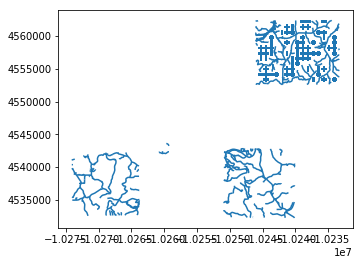

In [155]:
excludedByRoads.plot(ax=roadsDF.plot())

In [162]:
largerTest = airfieldEvaluationDataFrame[~airfieldEvaluationDataFrame.intersects(roadsDF.buffer(400).unary_union)]

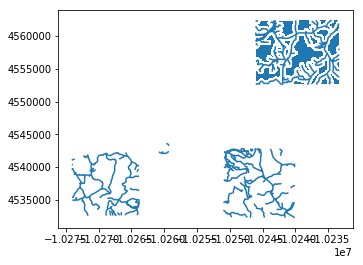

In [164]:
largerTest.plot(ax=roadsDF.plot())

# Imports

In [57]:
import SpatialIO as io
import FirstPass as firstpass
import pgdissroute as pgdissroute
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import random
%matplotlib inline
pd.options.display.max_columns = 200
reload(pgdissroute)
reload(firstpass)
reload(io)

<module 'SpatialIO' from 'SpatialIO.pyc'>

# Data Setup

In [156]:
slopePath = '../FLW_Missouri Mission Folder/RASTER/slope_proj.tif'
elevationPath = "../FLW_Missouri Mission Folder/RASTER/DEM_CMB_ELV_SRTMVF2_proj.tif"
vector_path = './test_data/UtilityInfrastructureCrv_3.shp'
roadsPath = './test_data/tgc.shp'
landcoverPath = '../FLW_Missouri Mission Folder/RASTER/LC_LandCover_GeoCover_proj.tif'

# Create AOI and Parameters

Text(0.5,0.98,u'Areas of Interest')

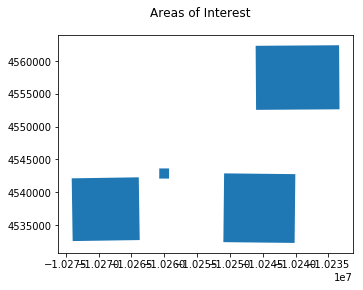

In [157]:
aoiDF = gpd.read_file("../FLW_Missouri Mission Folder/SUPPORT/Staging.shp")
aoiDF = aoiDF.to_crs({'init':'epsg:3857'})
squareDimension = 400
aoiDF.plot()
plt.suptitle("Areas of Interest")

## Get the geometries of AOIs for the input.xml

In [158]:
aoiDF_unproj = aoiDF.to_crs({'init':'epsg:4326'})
airfieldAOI = aoiDF_unproj[aoiDF_unproj['Stage']=='Gold'].reset_index().geometry[0]
baseObjective1AOI = aoiDF_unproj[aoiDF_unproj['Stage']=='Red'].reset_index().geometry[0]
baseObjective2AOI = aoiDF_unproj[aoiDF_unproj['Stage']=='Blue'].reset_index().geometry[0]
cbitec = aoiDF_unproj[aoiDF_unproj['Stage']=='White'].reset_index().geometry[0]

print "Airfield: %s" %(str(airfieldAOI.to_wkt()))
print "Red: %s" %(str(baseObjective1AOI.to_wkt()))
print "Blue: %s" %(str(baseObjective2AOI.to_wkt()))
print "CBITEC: %s" %(str(cbitec.to_wkt()))
print "CBITEC centroid: %s" %(cbitec.centroid)

projectedAirfield = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
print "projectedAirfield: %s" %(projectedAirfield.to_wkt())
print "projected airfield centroid: %s" %(projectedAirfield.centroid)

Airfield: POLYGON ((-92.0420407203899771 37.8786674360582936, -91.9278626441980151 37.8792673513784450, -91.9272790878007129 37.8100408421962086, -92.0414571639926606 37.8094403634696405, -92.0420407203899771 37.8786674360582936))
Red: POLYGON ((-92.2937812277846774 37.7353612509118079, -92.2020132175820066 37.7364461384693683, -92.2007296144230253 37.6685084584884251, -92.2924976246256676 37.6674225761625934, -92.2937812277846774 37.7353612509118079))
Blue: POLYGON ((-92.0852172668016209 37.7407181466318420, -91.9877289887035090 37.7398891889496539, -91.9887410491910629 37.6654206226553256, -92.0862293272891321 37.6662504135641640, -92.0852172668016209 37.7407181466318420))
CBITEC: POLYGON ((-92.1739596373465986 37.7460796171828790, -92.1605301799799008 37.7460417042094392, -92.1605803079124399 37.7350642138074619, -92.1740077823008477 37.7351021118712140, -92.1739596373465986 37.7460796171828790))
CBITEC centroid: POINT (-92.16726947722954 37.7405720468603)
projectedAirfield: POLYGON

# Parse the XML

In [159]:
from lxml import etree as ET
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
xmlPath = "input.xml"
tree = ET.parse(xmlPath)
root = tree.getroot()

In [160]:
siteSearches = root[0]
for siteSearch in siteSearches:
    print "%s: %s" %(siteSearch.tag, siteSearch.attrib)
    aoi = siteSearch.find("AreaOfInterest")
    aoiEPSG = aoi.attrib["EPSG"]
    aoiWKT = aoi.attrib["WKT"]
    aoiPolygon = loads(aoiWKT)   
    
    siteSuitability = siteSearch.find("SiteSuitability")
    for siteSuitabilityRow in siteSuitability:
        print "%s: %s" %(siteSuitabilityRow.tag, siteSuitabilityRow.attrib)

SiteSearch: {'type': 'Airfield', 'name': 'Gold', 'studyObjectiveID': '0'}


KeyError: 'EPSG'

# Airfield Objective

## Site Suitability

In [161]:
airfieldAOI = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
airfieldEvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(airfieldAOI,100)

Generated 12161 squares in 0 seconds


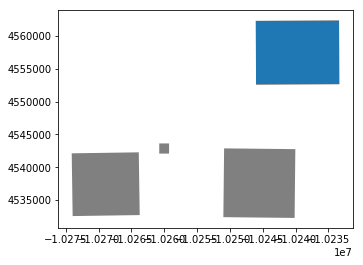

In [16]:
airfieldEvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))

In [8]:
airfieldSlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(airfieldEvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)


/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

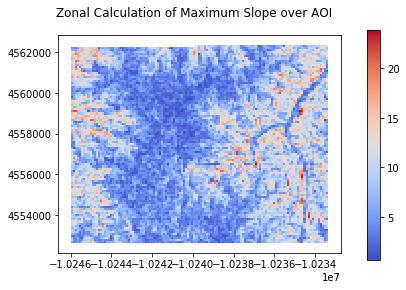

In [37]:
vmin = min(airfieldSlopeEvaluationDataFrame['max'])
vmax = max(airfieldSlopeEvaluationDataFrame['max'])
ax = airfieldSlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

Text(0,0.5,u'Fraction of AOI Evaluation Grid')

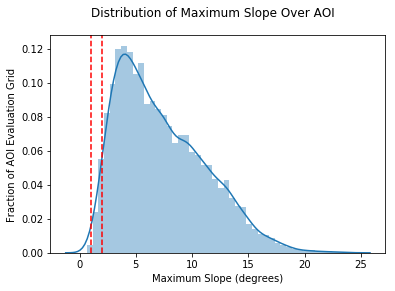

In [38]:
sns.distplot(airfieldSlopeEvaluationDataFrame['max'])
plt.axvline(1, color='red', linestyle='--')
plt.axvline(2, color='red', linestyle='--')
plt.suptitle("Distribution of Maximum Slope Over AOI")
plt.xlabel("Maximum Slope (degrees)")
plt.ylabel("Fraction of AOI Evaluation Grid")

**Subset by maximum slope < 2**

In [39]:
airfieldSlopeEvaluationDataFrameSubset = airfieldSlopeEvaluationDataFrame[airfieldSlopeEvaluationDataFrame['max'] < 2]
print "Subset consists of %s areas, reduced from the original %s areas" %(len(airfieldSlopeEvaluationDataFrameSubset.index),len(airfieldSlopeEvaluationDataFrame.index))

Subset consists of 364 areas, reduced from the original 12161 areas


364


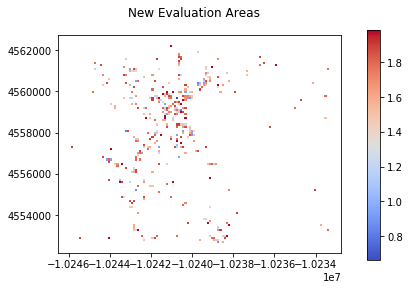

In [134]:
vmin = min(airfieldSlopeEvaluationDataFrameSubset['max'])
vmax = max(airfieldSlopeEvaluationDataFrameSubset['max'])
ax = airfieldSlopeEvaluationDataFrameSubset.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("New Evaluation Areas")
print len(airfieldSlopeEvaluationDataFrameSubset.index)

**Create Larger Candidate Sites Using the Simplified Approach**

**Distance to Linear Features**

In [60]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

In [42]:
lx,ly,ux,uy = airfieldEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

Text(0.5,0.98,u'Roads Near the AOI')

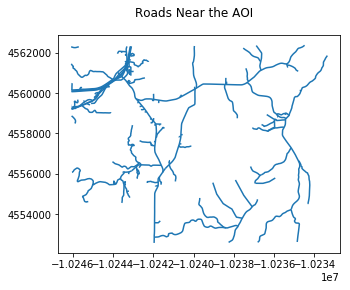

In [43]:
roadsDF.plot()
plt.suptitle("Roads Near the AOI")

In [44]:
airfieldEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(airfieldEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

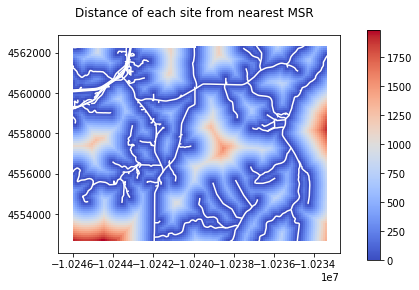

In [45]:
vmin = min(airfieldEvaluationDataFrame['distance'])
vmax = max(airfieldEvaluationDataFrame['distance'])
ax = airfieldEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

Text(0,0.5,u'Fraction of Candidate Sites')

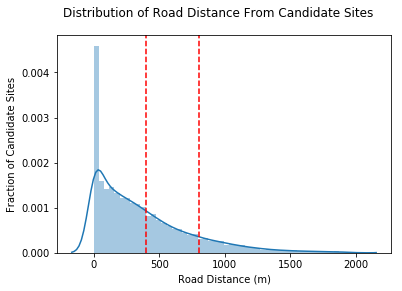

In [46]:
sns.distplot(airfieldEvaluationDataFrame['distance'])
plt.axvline(400, color='red', linestyle='--')
plt.axvline(800, color='red', linestyle='--')
plt.suptitle("Distribution of Road Distance From Candidate Sites")
plt.xlabel("Road Distance (m)")
plt.ylabel("Fraction of Candidate Sites")

## Site Configuration

In [47]:
largerPolygonDimension = 800
largerAirfields = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(airfieldSlopeEvaluationDataFrameSubset, largerPolygonDimension)

Text(0.5,0.98,u'Site Configuration for Airfield')

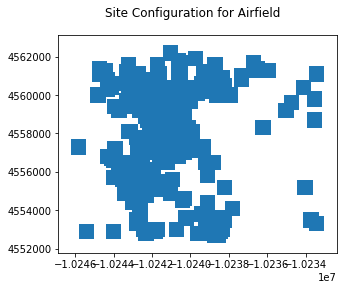

In [48]:
largerAirfields.plot()
plt.suptitle("Site Configuration for Airfield")

## Site Evaluation

**Calculate Cut Fill For Objective Function**

In [49]:
cutFillDF = firstpass.calculateCutFill(largerAirfields,elevationPath,finalElevation='mean',rasterResolution=1)

Text(0.5,0.98,u'Cut Fill Required for Candidate Airfields (m^3)')

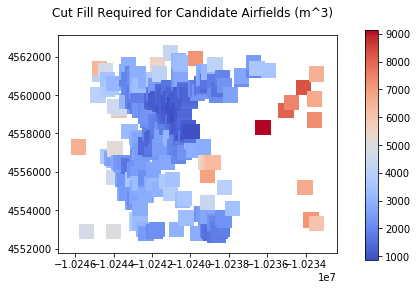

In [50]:
vmin = min(cutFillDF['totalCutFillVolume'])
vmax = max(cutFillDF['totalCutFillVolume'])
ax = cutFillDF.plot(column='totalCutFillVolume', cmap='coolwarm', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Cut Fill Required for Candidate Airfields (m^3)")

In [140]:
cutFillDF.head()

,index,max,geometry,old_geo,count,max,mean,min,mini_raster_affine,mini_raster_array,mini_raster_nodata,elevationChangeArray,totalCutFillVolume
0,142,1.897437,POLYGON ((-10246223.10456756 4556890.992403396...,POLYGON ((-10245873.10456756 4557240.992403396...,600,314.0,296.576667,264.0,"(34.1675152236, 0.0, -10246251.8449, 0.0, -34....","[[304, 304, 301, 297, 295, 293, 291, 293, 297,...",32767.0,"[[7.42333333333, 7.42333333333, 4.42333333333,...",6597.426667
1,482,1.897437,POLYGON ((-10245823.10456756 4552490.992403396...,POLYGON ((-10245473.10456756 4552840.992403396...,576,333.0,314.538194,285.0,"(34.1675152236, 0.0, -10245841.8347, 0.0, -34....","[[301, 301, 302, 304, 306, 307, 310, 313, 317,...",32767.0,"[[-13.5381944444, -13.5381944444, -12.53819444...",4678.638889
2,1129,1.802569,POLYGON ((-10245223.10456756 4559590.992403396...,POLYGON ((-10244873.10456756 4559940.992403396...,576,308.0,293.435764,257.0,"(34.1675152236, 0.0, -10245226.8195, 0.0, -34....","[[278, 279, 281, 285, 288, 294, 297, 298, 298,...",32767.0,"[[-15.4357638889, -14.4357638889, -12.43576388...",4048.909722
3,1236,1.185584,POLYGON ((-10245123.10456756 4560690.992403396...,POLYGON ((-10244773.10456756 4561040.992403396...,576,311.0,297.569444,269.0,"(34.1675152236, 0.0, -10245124.3169, 0.0, -34....","[[287, 290, 294, 297, 301, 303, 303, 301, 300,...",32767.0,"[[-10.5694444444, -7.56944444444, -3.569444444...",4019.805556
4,1239,1.778059,POLYGON ((-10245123.10456756 4560990.992403396...,POLYGON ((-10244773.10456756 4561340.992403396...,576,307.0,292.800347,251.0,"(34.1675152236, 0.0, -10245124.3169, 0.0, -34....","[[251, 254, 262, 267, 268, 268, 270, 271, 270,...",32767.0,"[[-41.8003472222, -38.8003472222, -30.80034722...",6456.138889


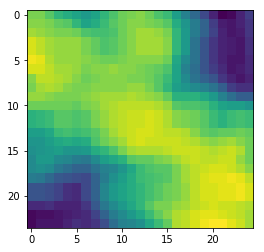

In [139]:
candidate1 = cutFillDF['mini_raster_array'][0]
plt.imshow(candidate1)

Text(0,0.5,u'Fraction of Candidate Sites')

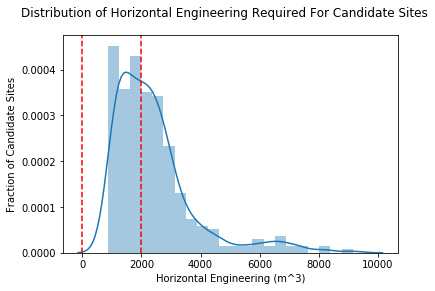

In [51]:
sns.distplot(cutFillDF['totalCutFillVolume'])
plt.axvline(0, color='red', linestyle='--')
plt.axvline(2000, color='red', linestyle='--')
plt.suptitle("Distribution of Horizontal Engineering Required For Candidate Sites")
plt.xlabel("Horizontal Engineering (m^3)")
plt.ylabel("Fraction of Candidate Sites")

# Camp 1 Objective

In [52]:
baseObjective1AOI = aoiDF[aoiDF['Stage']=='Red'].reset_index().geometry[0]
baseObjective1EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective1AOI,100)

Generated 9551 squares in 1 seconds


Text(0.5,0.98,u'Context: Location of Site 1')

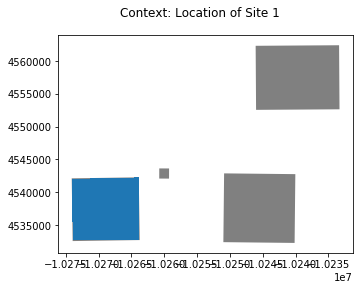

In [53]:
baseObjective1EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 1")

In [54]:
site1SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective1EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

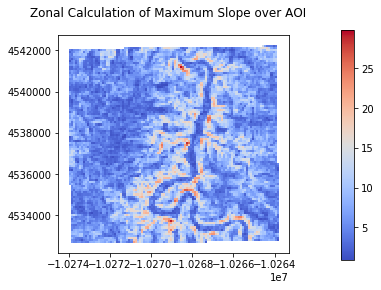

In [55]:
vmin = min(site1SlopeEvaluationDataFrame['max'])
vmax = max(site1SlopeEvaluationDataFrame['max'])
ax = site1SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [56]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site1SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site1SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site1SlopeEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

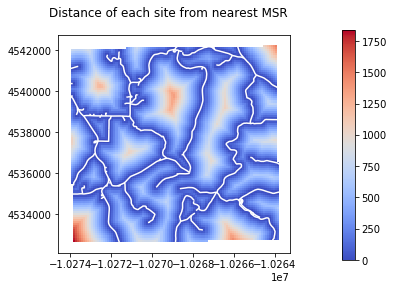

In [57]:
vmin = min(site1SlopeEvaluationDataFrame['distance'])
vmax = max(site1SlopeEvaluationDataFrame['distance'])
ax = site1SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Camp 2 Objective

In [58]:
baseObjective2AOI = aoiDF[aoiDF['Stage']=='Blue'].reset_index().geometry[0]
baseObjective2EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective2AOI,100)

Generated 11141 squares in 0 seconds


Text(0.5,0.98,u'Context: Location of Site 2')

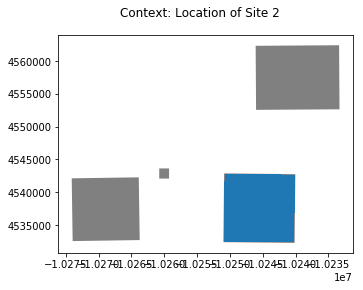

In [59]:
baseObjective2EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 2")

In [60]:
site2SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective2EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

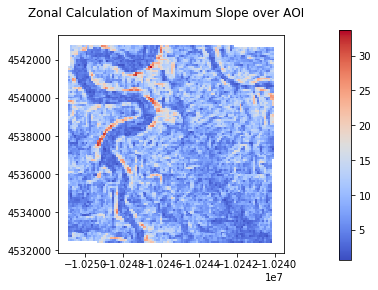

In [61]:
vmin = min(site2SlopeEvaluationDataFrame['max'])
vmax = max(site2SlopeEvaluationDataFrame['max'])
ax = site2SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [62]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site2SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site2SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site2SlopeEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

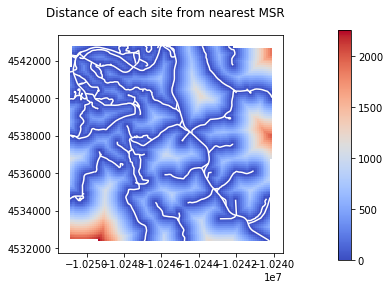

In [63]:
vmin = min(site2SlopeEvaluationDataFrame['distance'])
vmax = max(site2SlopeEvaluationDataFrame['distance'])
ax = site2SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Site Relations

**Set Up Three Candidate Solution DataFrames**

In [64]:
airfieldCandidates = cutFillDF[cutFillDF['totalCutFillVolume'] < 2000]
print "Evaluating %s candidates for the airfield site" %(len(airfieldCandidates.index))

Evaluating 170 candidates for the airfield site


In [65]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site1Candidates.index),100)
site1Candidates = site1Candidates.iloc[randomIndexes,:]
largerPolygonDimension = 400
site1Candidates = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(site1Candidates, largerPolygonDimension)
print "Evaluating %s candidates for the Site 1" %(len(site1Candidates.index))

Evaluating 100 candidates for the Site 1


In [66]:
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site2Candidates.index),100)
site2Candidates = site2Candidates.iloc[randomIndexes,:]
largerPolygonDimension = 400
site2Candidates = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(site2Candidates, largerPolygonDimension)
print "Evaluating %s candidates for the Site 1" %(len(site2Candidates.index))

Evaluating 100 candidates for the Site 1


Text(0.5,0.98,u'Candidate Sites for Relational Analysis')

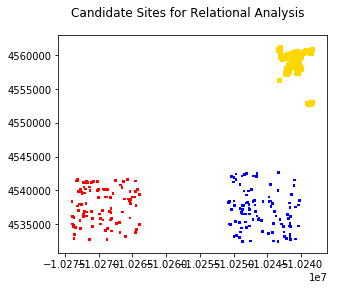

In [67]:
airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))
plt.suptitle("Candidate Sites for Relational Analysis")

In [68]:
class CandidateSolution:
    def __init__(self,geom1,geom2,geom3):
        self.geom1 = geom1
        self.geom2 = geom2
        self.geom3 = geom3

In [69]:
# generate solutionDF at random
geomDF = site1Candidates
geomDF.crs = {'init':'EPSG:3857'}
geomDF = geomDF.to_crs({'init':'EPSG:4326'})
heat_data1 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geomDF.index))
        randomCandidate = geomDF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data1.append(generation)
        

In [70]:
geom2DF = site2Candidates
geom2DF.crs = {'init':'EPSG:3857'}
geom2DF = geom2DF.to_crs({'init':'EPSG:4326'})
heat_data2 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geom2DF.index))
        randomCandidate = geom2DF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data2.append(generation)

In [71]:
airfieldDF = airfieldCandidates
airfieldDF.crs = {'init':'EPSG:3857'}
airfieldDF = airfieldDF.to_crs({'init':'EPSG:4326'})
heat_data3 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geom2DF.index))
        randomCandidate = airfieldDF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data3.append(generation)

In [72]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [73]:
weights=(-1.0,-1.0)
creator.create("FitnessMin", base.Fitness, weights=weights)
creator.create("Individual", list, fitness=creator.FitnessMin)

In [74]:
def evaluate(individual):
    try:
        # retreive geometries
        airfieldCandidate = airfieldDF
        airfieldCandidate.crs = {'init':'EPSG:3857'}
        airfieldCandidate = airfieldCandidate.to_crs({'init':'EPSG:4326'})
        airfieldCandidate = airfieldDF.iloc[individual[0],:]
        airfieldCentroidLon = float(airfieldCandidate['geometry'].centroid.x)
        airfieldCentroidLat = float(airfieldCandidate['geometry'].centroid.y)

        redCandidate = geomDF
        redCandidate.crs = {'init':'EPSG:3857'}
        redCandidate = redCandidate.to_crs({'init':'EPSG:4326'})
        redCandidate = geomDF.iloc[individual[1],:]
        redCentroidLon = float(redCandidate['geometry'].centroid.x)
        redCentroidLat = float(redCandidate['geometry'].centroid.y)

        blueCandidate = geom2DF
        blueCandidate.crs = {'init':'EPSG:3857'}
        blueCandidate = blueCandidate.to_crs({'init':'EPSG:4326'})
        blueCandidate = geom2DF.iloc[individual[2],:]
        blueCentroidLon = float(blueCandidate['geometry'].centroid.x)
        blueCentroidLat = float(blueCandidate['geometry'].centroid.y)

        # distance from airfield to site red
        redToAirfieldDistance = pgdissroute.calculateRouteDistance(airfieldCentroidLon,airfieldCentroidLat,redCentroidLon,redCentroidLat)
        # distance from airfield to site blue
        blueToAirfieldDistance = pgdissroute.calculateRouteDistance(airfieldCentroidLon,airfieldCentroidLat,blueCentroidLon,blueCentroidLat)

        # print for debugging
        print "red is %s m from airfield, at (%s,%s)" %(redToAirfieldDistance,redCentroidLon,redCentroidLat)
        print "blue is %s m from airfield, at (%s,%s)" %(blueToAirfieldDistance,blueCentroidLon,blueCentroidLat)
        return redToAirfieldDistance, blueToAirfieldDistance

    except Exception, e:
        print "Generated an error, returning very large number"
        return 999999,999999
        
        
    

def mutate(individual,probElementMutation=0.1):
    attrDictionary = {0: (0, len(airfieldCandidates.index)),
                  1: (0,len(geomDF.index)),
                      2: (0,len(geom2DF.index))}# nopep8
    for i in range(0,len(individual)):
        attr = individual[i]
        shouldWeMutate = np.random.random() <= probElementMutation
        if shouldWeMutate:
            newAttrLowerBound = attrDictionary[i][0]
            newAttrUpperBound = attrDictionary[i][1]
            newAttrValue = np.random.randint(newAttrLowerBound,newAttrUpperBound)
            individual[i] = newAttrValue
    return (individual,)

def createPopulation(populationSize):
    toolbox.register("index1",random.randint,0,len(airfieldCandidates.index))
    toolbox.register("index2",random.randint,0,len(geomDF.index))
    toolbox.register("index3",random.randint,0,len(geom2DF.index))
    genes = [toolbox.index1,toolbox.index2,toolbox.index3]
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     genes, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    population = toolbox.population(n=populationSize)
    return population

In [75]:
popSize = 10
nGenerations = 10
pMutation = 0.1
pCrossover = 0.5
maxElite = 4

In [76]:
toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selNSGA2)
population = createPopulation(popSize)
print population
hallOfFame = tools.ParetoFront()  
logbook = tools.Logbook()

[[113, 86, 80], [3, 25, 10], [135, 31, 75], [57, 34, 66], [162, 99, 87], [62, 25, 33], [153, 21, 49], [79, 26, 97], [25, 8, 13], [130, 61, 23]]


In [77]:
# perform the GA
stats = tools.Statistics(key= lambda ind: individual.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
for individual in population:
    individual.fitness.values = toolbox.evaluate(individual)
record = stats.compile(population)
hallOfFame.update(population)

for generation in range(0,nGenerations):
    print "GENERATION %s" %(generation)
    theBestIndividuals = []
    if len(hallOfFame.items) <= maxElite:
        theBestIndividuals = hallOfFame.items
    elif len(hallOfFame.items) > 0:
        theBestIndividuals = hallOfFame.items[0:maxElite]
    reducedOffspring = toolbox.select(population, len(population)-len(theBestIndividuals))
    offspring = theBestIndividuals + reducedOffspring   
   # Clone the selected individuals
    offspring = map(toolbox.clone, offspring)

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= pCrossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring, with a probability assigned to each gene  # nopep8
    for mutant in offspring:
        toolbox.mutate(mutant, pMutation)
        del mutant.fitness.values
    
     # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for individual in invalid_ind:
        individual.fitness.values = toolbox.evaluate(individual)
        
    # The population is entirely replaced by the offspring
    population[:] = offspring
    hallOfFame.update(population)
    record=stats.compile(population)
    
    allScores = []
    for individual in population: 
        allScores.append(individual.fitness.values)
            
    logbook.record(gen=generation, allIndividuals = list(population), allScores = allScores, top5 = theBestIndividuals[0], bestScore = theBestIndividuals[0].fitness.values,
                       **record)
    print theBestIndividuals[0], theBestIndividuals[0].fitness.values

red is 38977.7828759 m from airfield, at (-92.229551685,37.6862638016)
blue is 24948.1699938 m from airfield, at (-92.0399660902,37.6885277481)
red is 37154.6206992 m from airfield, at (-92.2403314684,37.7011911964)
blue is 22479.2295031 m from airfield, at (-92.0588307111,37.7077189749)
red is 39375.4064885 m from airfield, at (-92.2816539714,37.7189579859)
blue is 26160.4100494 m from airfield, at (-92.0067284246,37.6700426125)
red is 39795.131307 m from airfield, at (-92.283450602,37.6990588954)
blue is 23048.2165763 m from airfield, at (-92.0606273417,37.7155361985)
red is 44710.4540599 m from airfield, at (-92.2906371243,37.6819982797)
blue is 21786.9425715 m from airfield, at (-92.030084622,37.7084296656)
red is 38932.8548642 m from airfield, at (-92.2403314684,37.7011911964)
blue is 20012.556794 m from airfield, at (-92.0184065233,37.7205103659)
red is 40901.194886 m from airfield, at (-92.2457213601,37.7132730767)
blue is 25312.6283242 m from airfield, at (-92.0103216858,37.676

In [78]:
logbookDF = pd.DataFrame(logbook)

In [79]:
logbookDF

,allIndividuals,allScores,avg,bestScore,gen,max,min,std,top5
0,"[[79, 26, 97], [79, 26, 97], [25, 8, 33], [62,...","[(35770.0521184, 16543.9934719), (35770.052118...",31198.847635,"(35770.0521184, 16543.9934719)",0,37013.075370,25384.619900,5814.227735,"[79, 26, 97]"
1,"[[79, 26, 97], [79, 26, 97], [74, 8, 33], [25,...","[(35770.0521184, 16543.9934719), (35770.052118...",33866.440780,"(35770.0521184, 16543.9934719)",1,42974.568561,24758.312998,9108.127781,"[79, 26, 97]"
2,"[[79, 26, 97], [156, 26, 97], [79, 26, 97], [6...","[(35770.0521184, 16543.9934719), (35423.087679...",33101.158089,"(35283.094492, 20012.556794)",2,40817.696278,25384.619900,7716.538189,"[74, 41, 33]"
3,"[[74, 76, 97], [156, 26, 33], [156, 26, 97], [...","[(40845.5477318, 19634.2604094), (35423.087679...",31238.665123,"(35283.094492, 20012.556794)",3,40302.157300,22175.172947,9063.492177,"[74, 41, 33]"
4,"[[74, 41, 33], [156, 26, 97], [156, 26, 33], [...","[(35283.094492, 20012.556794), (35423.0876791,...",31238.665123,"(35283.094492, 19634.2604094)",4,40302.157300,22175.172947,9063.492177,"[74, 41, 97]"
5,"[[74, 41, 97], [169, 26, 97], [156, 26, 97], [...","[(35283.094492, 19634.2604094), (39711.3350773...",27356.539950,"(33021.9302668, 16575.3254172)",5,34084.967676,20628.112224,6728.427726,"[156, 29, 33]"
6,"[[156, 26, 33], [156, 47, 59], [156, 29, 97], ...","[(35423.0876791, 16575.3254172), (44168.475652...",29247.289733,"(31146.156139, 20628.1122242)",6,38860.319056,19634.260409,9613.029323,"[25, 79, 13]"
7,"[[25, 29, 97], [156, 79, 13], [156, 33, 13], [...","[(34084.9676757, 17260.0664415), (30083.118730...",28574.330980,"(30083.1187301, 19565.0748153)",7,39292.259798,17856.402161,10717.928819,"[156, 79, 13]"
8,"[[156, 79, 97], [25, 79, 13], [156, 29, 97], [...","[(30083.1187301, 16197.0290326), (31146.156139...",28765.351383,"(30083.1187301, 16197.0290326)",8,39292.259798,18238.442967,10526.908415,"[156, 79, 97]"
9,"[[156, 79, 97], [156, 79, 97], [156, 79, 97], ...","[(30083.1187301, 16197.0290326), (30083.118730...",32245.443144,"(30083.1187301, 16197.0290326)",9,32979.856125,31511.030163,734.412981,"[156, 79, 97]"


In [80]:
def convertLogBookIntoGenerationalCoordinates(logbookDF):
    airfieldDF = airfieldCandidates
    redDF = geomDF
    redDF.crs = {'init':'EPSG:4326'}
    blueDF = geom2DF
    blueDF.crs = {'init':'EPSG:4326'}
    airfieldDF.crs = {'init':'EPSG:3857'}
    airfieldDF = airfieldDF.to_crs({'init':'EPSG:4326'})
    heat_data = []
    # each row is one generation
    for i,row in logbookDF.iterrows():
        combinedLocations = []
        airfields = []
        reds = []
        blues = []
        rowInd = row['allIndividuals']
        for individual in rowInd:
            airfieldIndex = individual[0]
            redIndex = individual[1]
            blueIndex = individual[2]
            
            airfieldCandidate = airfieldDF.iloc[airfieldIndex,:].geometry
            airfieldCandidateCentroid = airfieldCandidate.centroid
            airfields.append([airfieldCandidateCentroid.y,airfieldCandidateCentroid.x])
            combinedLocations.append([airfieldCandidateCentroid.y,airfieldCandidateCentroid.x])
                   
            redCandidate = redDF.iloc[redIndex,:].geometry
            redCandidateCentroid = redCandidate.centroid
            reds.append([redCandidateCentroid.y,redCandidateCentroid.x]) 
            combinedLocations.append([redCandidateCentroid.y,redCandidateCentroid.x])
            
            blueCandidate = blueDF.iloc[blueIndex,:].geometry
            blueCandidateCentroid = blueCandidate.centroid
            blues.append([blueCandidateCentroid.y,blueCandidateCentroid.x])    
            combinedLocations.append([blueCandidateCentroid.y,blueCandidateCentroid.x])
        heat_data.append(combinedLocations)
    return heat_data

In [81]:
heat_data = convertLogBookIntoGenerationalCoordinates(logbookDF)

In [82]:
m = io.Map()
m.addTimeSeriesHeatMapFromArray(heat_data)
m.saveMap("./results/gaforpresentation3.html")
m.map

Map saved to ./results/gaforpresentation3.html


# Notes for Future Work

## Modeling Epistasis by Index

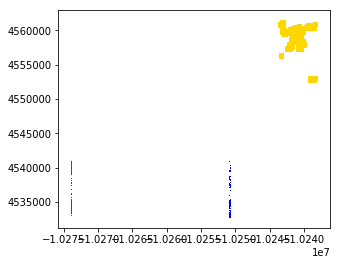

In [83]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
site1Candidates = site1Candidates[0:100]

site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
site2Candidates = site2Candidates[0:100]

airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))

Text(0.5,0.98,u'Demonstration of Epistasis: Candidate Sites by Index')

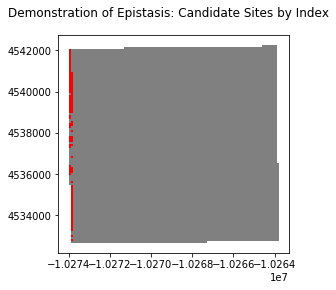

In [84]:
site1Candidates.plot(color='red',ax=site1SlopeEvaluationDataFrame.plot(color='grey'))
plt.suptitle("Demonstration of Epistasis: Candidate Sites by Index")

**Routing**

In [85]:
reload(pgdissroute)

<module 'pgdissroute' from 'pgdissroute.pyc'>

In [86]:
site1Candidates.crs = {"init":"EPSG:3857"}
site1Candidates_Projected = site1Candidates.to_crs({"init":"EPSG:4326"})

site2Candidates.crs = {"init":"EPSG:3857"}
site2Candidates_Projected = site2Candidates.to_crs({"init":"EPSG:4326"})

startLon = float(site1Candidates_Projected[0:1]['geometry'].centroid.x)
startLat = float(site1Candidates_Projected[0:1]['geometry'].centroid.y)

endLon = float(site2Candidates_Projected[0:1]['geometry'].centroid.x)
endLat = float(site2Candidates_Projected[0:1]['geometry'].centroid.y)

#startLon,startLat,endLon,endLat = -92.068859,37.846720,-92.142373,37.557935
df,m = pgdissroute.route(startLon,startLat,endLon,endLat)

In [87]:
m

In [89]:
sum(df['length_m'])

25534.73643089144

## Spatial Statistics

In [92]:
# PYSAL test, http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html
import pysal as ps
from sklearn import cluster
from sklearn.preprocessing import scale

In [96]:
testdf = geom2DF
testdf.head()

,max,mean,distance,geometry,old_geo
2719,3.452848,2.476910,0.573870,POLYGON ((-92.06332228754408 37.69421456901215...,POLYGON ((-10248292.15778644 4536468.193049984...
2673,3.613691,2.853306,0.000000,"POLYGON ((-92.0642206028282 37.73543087800659,...",POLYGON ((-10248392.15778644 4542268.193049984...
1748,6.553271,4.447533,1840.345683,"POLYGON ((-92.07140712510116 37.6693315674448,...",POLYGON ((-10249192.15778644 4532968.193049984...
2211,6.553271,4.060045,341.395740,POLYGON ((-92.06781386396467 37.70274396227281...,POLYGON ((-10248792.15778644 4537668.193049984...
149,4.956807,3.176795,155.021773,POLYGON ((-92.08578016964708 37.70629758650176...,POLYGON ((-10250792.15778644 4538168.193049984...


In [95]:
km5 = cluster.KMeans(n_clusters=5)

In [100]:
km5cls = km5.fit(testdf.drop(['geometry','old_geo'],axis=1).values)

In [101]:
km5cls

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

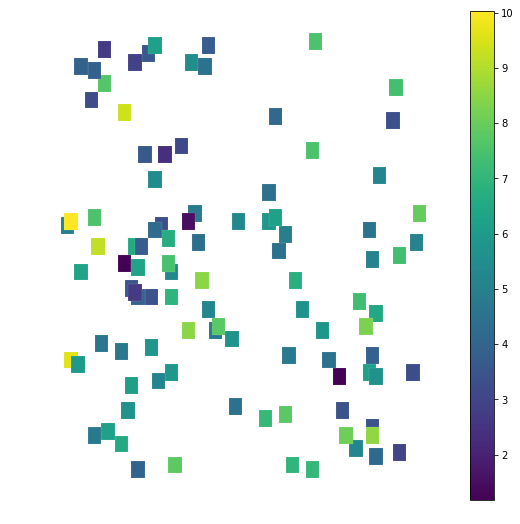

In [103]:
f, ax = plt.subplots(1, figsize=(9, 9))
testdf.assign(cl=km5cls.labels_)\
   .plot(column='max', categorical=False, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [104]:
"""More References
http://colorbrewer2.org/#type=sequential&scheme=Oranges&n=3
http://darribas.org/gds_scipy16/ipynb_md/02_geovisualization.html
"""

'More References\nhttp://colorbrewer2.org/#type=sequential&scheme=Oranges&n=3\nhttp://darribas.org/gds_scipy16/ipynb_md/02_geovisualization.html\n'

In [110]:
airfieldSlopeEvaluationDataFrame.head()

,geometry,max,mean
0,POLYGON ((-10245973.10456756 4552640.992403396...,5.061002,2.802289
1,POLYGON ((-10245973.10456756 4552740.992403396...,8.866053,5.062748
2,POLYGON ((-10245973.10456756 4552840.992403396...,7.683767,4.688569
3,POLYGON ((-10245973.10456756 4552940.992403396...,3.270710,2.385965
4,POLYGON ((-10245973.10456756 4553040.992403396...,6.088213,4.847655


## Coverage Model

In [ ]:
testDF = airfieldSlopeEvaluationDataFrame[0:1]
testDF.crs = {'init':'EPSG:3857'}
testDF = testDF.to_crs({'init':'EPSG:4326'})
centroid = testDF['geometry'].centroid
nearestNodeDF = pgdissroute.get_nearest_node(float(centroid.x),float(centroid.y))

In [ ]:
nodes,edges,map2 = pgdissroute.drivingDistance(nearestNodeDF['node_id'][0],0.1,mapPath="./results/mapwithdrivedistance.html")


In [ ]:
map2